In [1]:
import numpy as np
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from typing import List, Optional, Tuple

import corner

In [2]:
from starccato_flow.data.ccsn_data import CCSNData
from starccato_flow.data.toy_data import ToyData
from starccato_flow.training.trainer_flow_matching_new import FlowMatchingTrainerNew

MPS device found


/Users/tarineccleston/Desktop/starccato/starccato-flow/.venv/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from starccato_flow.utils.defaults import DEVICE

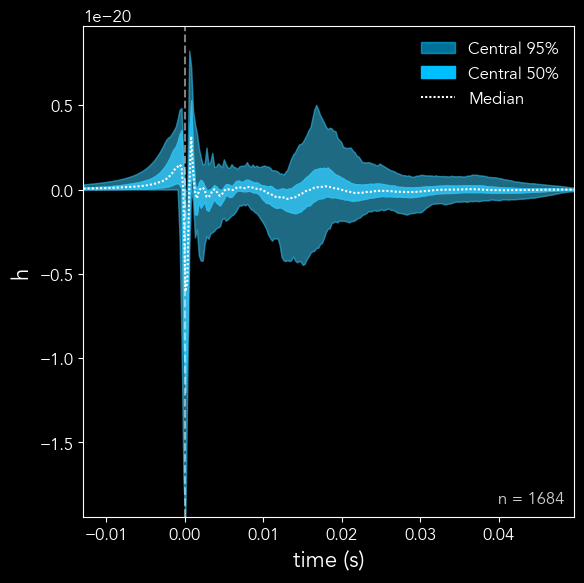

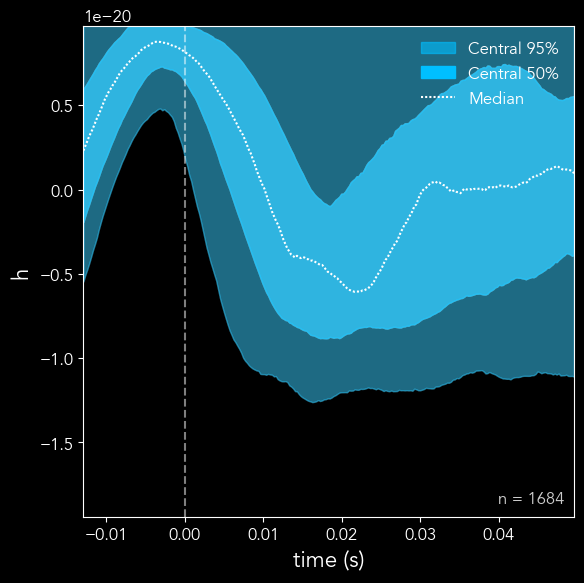

In [4]:
ccsn_dataset = CCSNData(noise=True, curriculum=False)
ccsn_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/ccsn_signal_distribution.svg")

toy_dataset = ToyData(noise=False, curriculum=False)
toy_dataset.plot_signal_distribution(background="black", font_family="sans-serif", font_name="Avenir", fname="plots/toy_signal_distribution.svg")

In [5]:
trainer = FlowMatchingTrainerNew(
    toy=False, 
    num_epochs=256,
    start_snr=200,
    end_snr=10,
    noise=False, 
    validation_split=0.1,
    curriculum=False,
    noise_realizations=1
)

# trainer.plot_candidate_signal(
#     snr=30,
#     index=60,
#     background="black"
# )


=== Data Split (on base signals) ===
Total base signals: 1684
Training base signals: 1516
Validation base signals: 168
First 5 training indices: [ 360  336   81  684 1374]
First 5 validation indices: [722 519 222  32 111]

Verifying data alignment:
Number of signals: 1516
Number of parameter sets: 1516
Parameter names: ['beta1_IC_b', 'omega_0(rad|s)', 'A(km)', 'Ye_c_b']
First few parameter values:
[[1.44351587e-01 8.50000000e+00 4.67000000e+02 2.64719754e-01]
 [1.21586226e-01 1.00000000e+01 3.00000000e+02 2.64719695e-01]
 [1.72128841e-01 1.25000000e+01 3.00000000e+02 2.77919501e-01]
 [1.44155603e-03 1.00000000e+00 3.00000000e+02 2.82819986e-01]
 [4.78845723e-02 4.00000000e+00 6.34000000e+02 2.81699777e-01]]

Verifying data alignment:
Number of signals: 168
Number of parameter sets: 168
Parameter names: ['beta1_IC_b', 'omega_0(rad|s)', 'A(km)', 'Ye_c_b']
First few parameter values:
[[4.6670679e-02 4.5000000e+00 4.6700000e+02 2.8281993e-01]
 [1.7992939e-01 1.3000000e+01 3.0000000e+02 2.

In [6]:
trainer.train()

Epochs:   0%|          | 1/256 [00:04<17:50,  4.20s/it]

Epoch 1/256 | Train MSE Loss: 0.0358 | Val MSE Loss: 0.0391


Epochs:   1%|          | 2/256 [00:05<11:28,  2.71s/it]

Epoch 2/256 | Train MSE Loss: 0.0277 | Val MSE Loss: 0.0351


Epochs:   1%|          | 3/256 [00:07<09:43,  2.30s/it]

Epoch 3/256 | Train MSE Loss: 0.0285 | Val MSE Loss: 0.0309


Epochs:   2%|▏         | 4/256 [00:09<08:41,  2.07s/it]

Epoch 4/256 | Train MSE Loss: 0.0274 | Val MSE Loss: 0.0301


Epochs:   2%|▏         | 5/256 [00:11<07:57,  1.90s/it]

Epoch 5/256 | Train MSE Loss: 0.0277 | Val MSE Loss: 0.0309


Epochs:   2%|▏         | 6/256 [00:12<07:32,  1.81s/it]

Epoch 6/256 | Train MSE Loss: 0.0279 | Val MSE Loss: 0.0355


Epochs:   3%|▎         | 7/256 [00:14<07:08,  1.72s/it]

Epoch 7/256 | Train MSE Loss: 0.0278 | Val MSE Loss: 0.0325


Epochs:   3%|▎         | 8/256 [00:15<06:55,  1.67s/it]

Epoch 8/256 | Train MSE Loss: 0.0270 | Val MSE Loss: 0.0324


Epochs:   4%|▎         | 9/256 [00:17<06:46,  1.65s/it]

Epoch 9/256 | Train MSE Loss: 0.0265 | Val MSE Loss: 0.0326


Epochs:   4%|▍         | 10/256 [00:18<06:40,  1.63s/it]

Epoch 10/256 | Train MSE Loss: 0.0269 | Val MSE Loss: 0.0281


Epochs:   4%|▍         | 11/256 [00:20<06:34,  1.61s/it]

Epoch 11/256 | Train MSE Loss: 0.0271 | Val MSE Loss: 0.0307


Epochs:   5%|▍         | 12/256 [00:22<06:30,  1.60s/it]

Epoch 12/256 | Train MSE Loss: 0.0272 | Val MSE Loss: 0.0328


Epochs:   5%|▌         | 13/256 [00:23<06:26,  1.59s/it]

Epoch 13/256 | Train MSE Loss: 0.0258 | Val MSE Loss: 0.0327


Epochs:   5%|▌         | 14/256 [00:25<06:24,  1.59s/it]

Epoch 14/256 | Train MSE Loss: 0.0266 | Val MSE Loss: 0.0350


Epochs:   6%|▌         | 15/256 [00:26<06:22,  1.59s/it]

Epoch 15/256 | Train MSE Loss: 0.0268 | Val MSE Loss: 0.0305


Epochs:   6%|▋         | 16/256 [00:28<06:20,  1.58s/it]

Epoch 16/256 | Train MSE Loss: 0.0267 | Val MSE Loss: 0.0305


Epochs:   7%|▋         | 17/256 [00:29<06:17,  1.58s/it]

Epoch 17/256 | Train MSE Loss: 0.0249 | Val MSE Loss: 0.0275


Epochs:   7%|▋         | 18/256 [00:31<06:16,  1.58s/it]

Epoch 18/256 | Train MSE Loss: 0.0257 | Val MSE Loss: 0.0269


Epochs:   7%|▋         | 19/256 [00:33<06:12,  1.57s/it]

Epoch 19/256 | Train MSE Loss: 0.0261 | Val MSE Loss: 0.0301


Epochs:   8%|▊         | 20/256 [00:34<06:11,  1.58s/it]

Epoch 20/256 | Train MSE Loss: 0.0253 | Val MSE Loss: 0.0262


Epochs:   8%|▊         | 21/256 [00:36<06:10,  1.58s/it]

Epoch 21/256 | Train MSE Loss: 0.0251 | Val MSE Loss: 0.0308


Epochs:   9%|▊         | 22/256 [00:37<06:09,  1.58s/it]

Epoch 22/256 | Train MSE Loss: 0.0238 | Val MSE Loss: 0.0301


Epochs:   9%|▉         | 23/256 [00:39<06:07,  1.58s/it]

Epoch 23/256 | Train MSE Loss: 0.0248 | Val MSE Loss: 0.0301


Epochs:   9%|▉         | 24/256 [00:40<06:06,  1.58s/it]

Epoch 24/256 | Train MSE Loss: 0.0248 | Val MSE Loss: 0.0315


Epochs:  10%|▉         | 25/256 [00:42<06:04,  1.58s/it]

Epoch 25/256 | Train MSE Loss: 0.0243 | Val MSE Loss: 0.0319


Epochs:  10%|█         | 26/256 [00:44<06:03,  1.58s/it]

Epoch 26/256 | Train MSE Loss: 0.0254 | Val MSE Loss: 0.0295


Epochs:  11%|█         | 27/256 [00:45<06:01,  1.58s/it]

Epoch 27/256 | Train MSE Loss: 0.0243 | Val MSE Loss: 0.0309


Epochs:  11%|█         | 28/256 [00:47<06:00,  1.58s/it]

Epoch 28/256 | Train MSE Loss: 0.0243 | Val MSE Loss: 0.0282


Epochs:  11%|█▏        | 29/256 [00:48<05:58,  1.58s/it]

Epoch 29/256 | Train MSE Loss: 0.0242 | Val MSE Loss: 0.0294


Epochs:  12%|█▏        | 30/256 [00:50<06:00,  1.59s/it]

Epoch 30/256 | Train MSE Loss: 0.0239 | Val MSE Loss: 0.0271


Epochs:  12%|█▏        | 31/256 [00:52<05:56,  1.59s/it]

Epoch 31/256 | Train MSE Loss: 0.0241 | Val MSE Loss: 0.0292


Epochs:  12%|█▎        | 32/256 [00:53<05:55,  1.59s/it]

Epoch 32/256 | Train MSE Loss: 0.0241 | Val MSE Loss: 0.0298


Epochs:  13%|█▎        | 33/256 [00:55<05:53,  1.58s/it]

Epoch 33/256 | Train MSE Loss: 0.0229 | Val MSE Loss: 0.0266


Epochs:  13%|█▎        | 34/256 [00:56<05:50,  1.58s/it]

Epoch 34/256 | Train MSE Loss: 0.0231 | Val MSE Loss: 0.0260


Epochs:  14%|█▎        | 35/256 [00:58<05:48,  1.58s/it]

Epoch 35/256 | Train MSE Loss: 0.0225 | Val MSE Loss: 0.0286


Epochs:  14%|█▍        | 36/256 [00:59<05:46,  1.57s/it]

Epoch 36/256 | Train MSE Loss: 0.0233 | Val MSE Loss: 0.0244


Epochs:  14%|█▍        | 37/256 [01:01<05:45,  1.58s/it]

Epoch 37/256 | Train MSE Loss: 0.0222 | Val MSE Loss: 0.0291


Epochs:  15%|█▍        | 38/256 [01:03<05:43,  1.58s/it]

Epoch 38/256 | Train MSE Loss: 0.0239 | Val MSE Loss: 0.0245


Epochs:  15%|█▌        | 39/256 [01:04<05:42,  1.58s/it]

Epoch 39/256 | Train MSE Loss: 0.0222 | Val MSE Loss: 0.0269


Epochs:  16%|█▌        | 40/256 [01:06<05:40,  1.57s/it]

Epoch 40/256 | Train MSE Loss: 0.0234 | Val MSE Loss: 0.0275


Epochs:  16%|█▌        | 41/256 [01:07<05:39,  1.58s/it]

Epoch 41/256 | Train MSE Loss: 0.0219 | Val MSE Loss: 0.0224


Epochs:  16%|█▋        | 42/256 [01:09<05:37,  1.58s/it]

Epoch 42/256 | Train MSE Loss: 0.0215 | Val MSE Loss: 0.0272


Epochs:  17%|█▋        | 43/256 [01:11<05:36,  1.58s/it]

Epoch 43/256 | Train MSE Loss: 0.0215 | Val MSE Loss: 0.0259


Epochs:  17%|█▋        | 44/256 [01:12<05:48,  1.64s/it]

Epoch 44/256 | Train MSE Loss: 0.0224 | Val MSE Loss: 0.0276


Epochs:  18%|█▊        | 45/256 [01:14<05:46,  1.64s/it]

Epoch 45/256 | Train MSE Loss: 0.0213 | Val MSE Loss: 0.0232


Epochs:  18%|█▊        | 46/256 [01:16<05:43,  1.64s/it]

Epoch 46/256 | Train MSE Loss: 0.0222 | Val MSE Loss: 0.0256


Epochs:  18%|█▊        | 47/256 [01:17<05:43,  1.64s/it]

Epoch 47/256 | Train MSE Loss: 0.0220 | Val MSE Loss: 0.0255


Epochs:  19%|█▉        | 48/256 [01:19<05:42,  1.65s/it]

Epoch 48/256 | Train MSE Loss: 0.0207 | Val MSE Loss: 0.0248


Epochs:  19%|█▉        | 49/256 [01:21<05:42,  1.65s/it]

Epoch 49/256 | Train MSE Loss: 0.0219 | Val MSE Loss: 0.0280


Epochs:  20%|█▉        | 50/256 [01:22<05:43,  1.67s/it]

Epoch 50/256 | Train MSE Loss: 0.0216 | Val MSE Loss: 0.0287


Epochs:  20%|█▉        | 51/256 [01:24<05:40,  1.66s/it]

Epoch 51/256 | Train MSE Loss: 0.0209 | Val MSE Loss: 0.0251


Epochs:  20%|██        | 52/256 [01:26<05:37,  1.65s/it]

Epoch 52/256 | Train MSE Loss: 0.0217 | Val MSE Loss: 0.0265


Epochs:  21%|██        | 53/256 [01:27<05:31,  1.63s/it]

Epoch 53/256 | Train MSE Loss: 0.0219 | Val MSE Loss: 0.0235


Epochs:  21%|██        | 54/256 [01:29<05:32,  1.65s/it]

Epoch 54/256 | Train MSE Loss: 0.0214 | Val MSE Loss: 0.0271


Epochs:  21%|██▏       | 55/256 [01:30<05:30,  1.64s/it]

Epoch 55/256 | Train MSE Loss: 0.0211 | Val MSE Loss: 0.0255


Epochs:  22%|██▏       | 56/256 [01:32<05:32,  1.66s/it]

Epoch 56/256 | Train MSE Loss: 0.0213 | Val MSE Loss: 0.0248


Epochs:  22%|██▏       | 57/256 [01:34<05:28,  1.65s/it]

Epoch 57/256 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0288


Epochs:  23%|██▎       | 58/256 [01:35<05:25,  1.65s/it]

Epoch 58/256 | Train MSE Loss: 0.0210 | Val MSE Loss: 0.0259


Epochs:  23%|██▎       | 59/256 [01:37<05:22,  1.64s/it]

Epoch 59/256 | Train MSE Loss: 0.0211 | Val MSE Loss: 0.0227


Epochs:  23%|██▎       | 60/256 [01:39<05:20,  1.63s/it]

Epoch 60/256 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0238


Epochs:  24%|██▍       | 61/256 [01:40<05:21,  1.65s/it]

Epoch 61/256 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0238


Epochs:  24%|██▍       | 62/256 [01:42<05:18,  1.64s/it]

Epoch 62/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0232


Epochs:  25%|██▍       | 63/256 [01:44<05:20,  1.66s/it]

Epoch 63/256 | Train MSE Loss: 0.0215 | Val MSE Loss: 0.0252


Epochs:  25%|██▌       | 64/256 [01:45<05:24,  1.69s/it]

Epoch 64/256 | Train MSE Loss: 0.0207 | Val MSE Loss: 0.0260


Epochs:  25%|██▌       | 65/256 [01:47<05:18,  1.67s/it]

Epoch 65/256 | Train MSE Loss: 0.0212 | Val MSE Loss: 0.0238


Epochs:  26%|██▌       | 66/256 [01:49<05:11,  1.64s/it]

Epoch 66/256 | Train MSE Loss: 0.0212 | Val MSE Loss: 0.0260


Epochs:  26%|██▌       | 67/256 [01:50<05:06,  1.62s/it]

Epoch 67/256 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0267


Epochs:  27%|██▋       | 68/256 [01:52<05:13,  1.67s/it]

Epoch 68/256 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0218


Epochs:  27%|██▋       | 69/256 [01:54<05:09,  1.66s/it]

Epoch 69/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0248


Epochs:  27%|██▋       | 70/256 [01:55<05:04,  1.64s/it]

Epoch 70/256 | Train MSE Loss: 0.0210 | Val MSE Loss: 0.0229


Epochs:  28%|██▊       | 71/256 [01:57<05:02,  1.64s/it]

Epoch 71/256 | Train MSE Loss: 0.0205 | Val MSE Loss: 0.0269


Epochs:  28%|██▊       | 72/256 [01:58<04:59,  1.63s/it]

Epoch 72/256 | Train MSE Loss: 0.0214 | Val MSE Loss: 0.0262


Epochs:  29%|██▊       | 73/256 [02:00<05:02,  1.65s/it]

Epoch 73/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0262


Epochs:  29%|██▉       | 74/256 [02:02<05:03,  1.67s/it]

Epoch 74/256 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0247


Epochs:  29%|██▉       | 75/256 [02:04<05:01,  1.67s/it]

Epoch 75/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0256


Epochs:  30%|██▉       | 76/256 [02:05<04:55,  1.64s/it]

Epoch 76/256 | Train MSE Loss: 0.0205 | Val MSE Loss: 0.0231


Epochs:  30%|███       | 77/256 [02:07<04:50,  1.62s/it]

Epoch 77/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0217


Epochs:  30%|███       | 78/256 [02:08<04:46,  1.61s/it]

Epoch 78/256 | Train MSE Loss: 0.0209 | Val MSE Loss: 0.0307


Epochs:  31%|███       | 79/256 [02:10<04:42,  1.60s/it]

Epoch 79/256 | Train MSE Loss: 0.0206 | Val MSE Loss: 0.0267


Epochs:  31%|███▏      | 80/256 [02:11<04:43,  1.61s/it]

Epoch 80/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0251


Epochs:  32%|███▏      | 81/256 [02:13<04:39,  1.60s/it]

Epoch 81/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0250


Epochs:  32%|███▏      | 82/256 [02:15<04:36,  1.59s/it]

Epoch 82/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0234


Epochs:  32%|███▏      | 83/256 [02:16<04:34,  1.59s/it]

Epoch 83/256 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0234


Epochs:  33%|███▎      | 84/256 [02:18<04:32,  1.58s/it]

Epoch 84/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0275


Epochs:  33%|███▎      | 85/256 [02:19<04:32,  1.59s/it]

Epoch 85/256 | Train MSE Loss: 0.0199 | Val MSE Loss: 0.0248


Epochs:  34%|███▎      | 86/256 [02:21<04:30,  1.59s/it]

Epoch 86/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0247


Epochs:  34%|███▍      | 87/256 [02:23<04:27,  1.58s/it]

Epoch 87/256 | Train MSE Loss: 0.0196 | Val MSE Loss: 0.0250


Epochs:  34%|███▍      | 88/256 [02:24<04:25,  1.58s/it]

Epoch 88/256 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0249


Epochs:  35%|███▍      | 89/256 [02:26<04:23,  1.58s/it]

Epoch 89/256 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0248


Epochs:  35%|███▌      | 90/256 [02:27<04:24,  1.59s/it]

Epoch 90/256 | Train MSE Loss: 0.0208 | Val MSE Loss: 0.0260


Epochs:  36%|███▌      | 91/256 [02:29<04:22,  1.59s/it]

Epoch 91/256 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0246


Epochs:  36%|███▌      | 92/256 [02:30<04:19,  1.58s/it]

Epoch 92/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0213


Epochs:  36%|███▋      | 93/256 [02:32<04:17,  1.58s/it]

Epoch 93/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0300


Epochs:  37%|███▋      | 94/256 [02:34<04:15,  1.58s/it]

Epoch 94/256 | Train MSE Loss: 0.0212 | Val MSE Loss: 0.0227


Epochs:  37%|███▋      | 95/256 [02:35<04:13,  1.58s/it]

Epoch 95/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0233


Epochs:  38%|███▊      | 96/256 [02:37<04:12,  1.58s/it]

Epoch 96/256 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0247


Epochs:  38%|███▊      | 97/256 [02:38<04:10,  1.57s/it]

Epoch 97/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0231


Epochs:  38%|███▊      | 98/256 [02:40<04:11,  1.59s/it]

Epoch 98/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0232


Epochs:  39%|███▊      | 99/256 [02:42<04:09,  1.59s/it]

Epoch 99/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0268


Epochs:  39%|███▉      | 100/256 [02:43<04:07,  1.58s/it]

Epoch 100/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0243


Epochs:  39%|███▉      | 101/256 [02:45<04:05,  1.58s/it]

Epoch 101/256 | Train MSE Loss: 0.0196 | Val MSE Loss: 0.0265


Epochs:  40%|███▉      | 102/256 [02:46<04:03,  1.58s/it]

Epoch 102/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0252


Epochs:  40%|████      | 103/256 [02:48<04:01,  1.58s/it]

Epoch 103/256 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0235


Epochs:  41%|████      | 104/256 [02:49<03:59,  1.58s/it]

Epoch 104/256 | Train MSE Loss: 0.0203 | Val MSE Loss: 0.0211


Epochs:  41%|████      | 105/256 [02:51<03:58,  1.58s/it]

Epoch 105/256 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0233


Epochs:  41%|████▏     | 106/256 [02:53<04:07,  1.65s/it]

Epoch 106/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0230


Epochs:  42%|████▏     | 107/256 [02:54<04:05,  1.65s/it]

Epoch 107/256 | Train MSE Loss: 0.0201 | Val MSE Loss: 0.0279


Epochs:  42%|████▏     | 108/256 [02:56<04:05,  1.66s/it]

Epoch 108/256 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0231


Epochs:  43%|████▎     | 109/256 [02:58<04:07,  1.69s/it]

Epoch 109/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0217


Epochs:  43%|████▎     | 110/256 [02:59<03:59,  1.64s/it]

Epoch 110/256 | Train MSE Loss: 0.0196 | Val MSE Loss: 0.0216


Epochs:  43%|████▎     | 111/256 [03:01<03:58,  1.64s/it]

Epoch 111/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0243


Epochs:  44%|████▍     | 112/256 [03:03<03:57,  1.65s/it]

Epoch 112/256 | Train MSE Loss: 0.0202 | Val MSE Loss: 0.0196


Epochs:  44%|████▍     | 113/256 [03:04<03:56,  1.65s/it]

Epoch 113/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0231


Epochs:  45%|████▍     | 114/256 [03:06<03:52,  1.64s/it]

Epoch 114/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0257


Epochs:  45%|████▍     | 115/256 [03:08<03:54,  1.67s/it]

Epoch 115/256 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0215


Epochs:  45%|████▌     | 116/256 [03:09<03:52,  1.66s/it]

Epoch 116/256 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0265


Epochs:  46%|████▌     | 117/256 [03:11<03:54,  1.69s/it]

Epoch 117/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0263


Epochs:  46%|████▌     | 118/256 [03:13<03:48,  1.65s/it]

Epoch 118/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0204


Epochs:  46%|████▋     | 119/256 [03:14<03:48,  1.67s/it]

Epoch 119/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0229


Epochs:  47%|████▋     | 120/256 [03:16<03:52,  1.71s/it]

Epoch 120/256 | Train MSE Loss: 0.0196 | Val MSE Loss: 0.0203


Epochs:  47%|████▋     | 121/256 [03:18<04:05,  1.82s/it]

Epoch 121/256 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0200


Epochs:  48%|████▊     | 122/256 [03:20<04:07,  1.84s/it]

Epoch 122/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0246


Epochs:  48%|████▊     | 123/256 [03:22<03:54,  1.76s/it]

Epoch 123/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0231


Epochs:  48%|████▊     | 124/256 [03:23<03:45,  1.71s/it]

Epoch 124/256 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0289


Epochs:  49%|████▉     | 125/256 [03:25<03:36,  1.66s/it]

Epoch 125/256 | Train MSE Loss: 0.0204 | Val MSE Loss: 0.0259


Epochs:  49%|████▉     | 126/256 [03:26<03:31,  1.63s/it]

Epoch 126/256 | Train MSE Loss: 0.0198 | Val MSE Loss: 0.0231


Epochs:  50%|████▉     | 127/256 [03:28<03:33,  1.65s/it]

Epoch 127/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0239


Epochs:  50%|█████     | 128/256 [03:30<03:34,  1.67s/it]

Epoch 128/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0229


Epochs:  50%|█████     | 129/256 [03:31<03:27,  1.63s/it]

Epoch 129/256 | Train MSE Loss: 0.0197 | Val MSE Loss: 0.0260


Epochs:  51%|█████     | 130/256 [03:33<03:23,  1.62s/it]

Epoch 130/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0223


Epochs:  51%|█████     | 131/256 [03:35<03:21,  1.62s/it]

Epoch 131/256 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0252


Epochs:  52%|█████▏    | 132/256 [03:36<03:21,  1.63s/it]

Epoch 132/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0233


Epochs:  52%|█████▏    | 133/256 [03:38<03:23,  1.65s/it]

Epoch 133/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0266


Epochs:  52%|█████▏    | 134/256 [03:40<03:25,  1.68s/it]

Epoch 134/256 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0268


Epochs:  53%|█████▎    | 135/256 [03:41<03:22,  1.67s/it]

Epoch 135/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0216


Epochs:  53%|█████▎    | 136/256 [03:43<03:21,  1.68s/it]

Epoch 136/256 | Train MSE Loss: 0.0200 | Val MSE Loss: 0.0247


Epochs:  54%|█████▎    | 137/256 [03:45<03:19,  1.67s/it]

Epoch 137/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0236


Epochs:  54%|█████▍    | 138/256 [03:46<03:16,  1.67s/it]

Epoch 138/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0262


Epochs:  54%|█████▍    | 139/256 [03:48<03:17,  1.68s/it]

Epoch 139/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0237


Epochs:  55%|█████▍    | 140/256 [03:50<03:13,  1.67s/it]

Epoch 140/256 | Train MSE Loss: 0.0193 | Val MSE Loss: 0.0243


Epochs:  55%|█████▌    | 141/256 [03:51<03:10,  1.66s/it]

Epoch 141/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0249


Epochs:  55%|█████▌    | 142/256 [03:53<03:10,  1.67s/it]

Epoch 142/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0246


Epochs:  56%|█████▌    | 143/256 [03:55<03:12,  1.71s/it]

Epoch 143/256 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0228


Epochs:  56%|█████▋    | 144/256 [03:56<03:08,  1.68s/it]

Epoch 144/256 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0227


Epochs:  57%|█████▋    | 145/256 [03:58<03:04,  1.66s/it]

Epoch 145/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0232


Epochs:  57%|█████▋    | 146/256 [04:00<03:03,  1.66s/it]

Epoch 146/256 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0201


Epochs:  57%|█████▋    | 147/256 [04:01<02:59,  1.65s/it]

Epoch 147/256 | Train MSE Loss: 0.0191 | Val MSE Loss: 0.0217


Epochs:  58%|█████▊    | 148/256 [04:03<02:56,  1.64s/it]

Epoch 148/256 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0225


Epochs:  58%|█████▊    | 149/256 [04:05<02:56,  1.65s/it]

Epoch 149/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0239


Epochs:  59%|█████▊    | 150/256 [04:06<02:54,  1.65s/it]

Epoch 150/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0206


Epochs:  59%|█████▉    | 151/256 [04:08<02:53,  1.65s/it]

Epoch 151/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0218


Epochs:  59%|█████▉    | 152/256 [04:10<02:51,  1.65s/it]

Epoch 152/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0239


Epochs:  60%|█████▉    | 153/256 [04:11<02:51,  1.67s/it]

Epoch 153/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0211


Epochs:  60%|██████    | 154/256 [04:13<02:47,  1.65s/it]

Epoch 154/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0213


Epochs:  61%|██████    | 155/256 [04:15<02:44,  1.63s/it]

Epoch 155/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0200


Epochs:  61%|██████    | 156/256 [04:16<02:43,  1.64s/it]

Epoch 156/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0248


Epochs:  61%|██████▏   | 157/256 [04:18<02:43,  1.65s/it]

Epoch 157/256 | Train MSE Loss: 0.0194 | Val MSE Loss: 0.0218


Epochs:  62%|██████▏   | 158/256 [04:20<02:42,  1.66s/it]

Epoch 158/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0235


Epochs:  62%|██████▏   | 159/256 [04:21<02:43,  1.69s/it]

Epoch 159/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0208


Epochs:  62%|██████▎   | 160/256 [04:23<02:42,  1.70s/it]

Epoch 160/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0187


Epochs:  63%|██████▎   | 161/256 [04:25<02:42,  1.71s/it]

Epoch 161/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0215


Epochs:  63%|██████▎   | 162/256 [04:26<02:41,  1.72s/it]

Epoch 162/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0248


Epochs:  64%|██████▎   | 163/256 [04:28<02:40,  1.72s/it]

Epoch 163/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0253


Epochs:  64%|██████▍   | 164/256 [04:30<02:38,  1.72s/it]

Epoch 164/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0260


Epochs:  64%|██████▍   | 165/256 [04:32<02:37,  1.73s/it]

Epoch 165/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0218


Epochs:  65%|██████▍   | 166/256 [04:33<02:35,  1.73s/it]

Epoch 166/256 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0210


Epochs:  65%|██████▌   | 167/256 [04:35<02:33,  1.72s/it]

Epoch 167/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0212


Epochs:  66%|██████▌   | 168/256 [04:37<02:32,  1.73s/it]

Epoch 168/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0213


Epochs:  66%|██████▌   | 169/256 [04:39<02:29,  1.72s/it]

Epoch 169/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0184


Epochs:  66%|██████▋   | 170/256 [04:40<02:28,  1.72s/it]

Epoch 170/256 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0200


Epochs:  67%|██████▋   | 171/256 [04:42<02:27,  1.73s/it]

Epoch 171/256 | Train MSE Loss: 0.0195 | Val MSE Loss: 0.0219


Epochs:  67%|██████▋   | 172/256 [04:44<02:25,  1.73s/it]

Epoch 172/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0218


Epochs:  68%|██████▊   | 173/256 [04:45<02:23,  1.73s/it]

Epoch 173/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0255


Epochs:  68%|██████▊   | 174/256 [04:47<02:22,  1.73s/it]

Epoch 174/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0236


Epochs:  68%|██████▊   | 175/256 [04:49<02:17,  1.69s/it]

Epoch 175/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0232


Epochs:  69%|██████▉   | 176/256 [04:50<02:14,  1.68s/it]

Epoch 176/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0213


Epochs:  69%|██████▉   | 177/256 [04:52<02:11,  1.67s/it]

Epoch 177/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0249


Epochs:  70%|██████▉   | 178/256 [04:54<02:08,  1.65s/it]

Epoch 178/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0216


Epochs:  70%|██████▉   | 179/256 [04:55<02:05,  1.63s/it]

Epoch 179/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0262


Epochs:  70%|███████   | 180/256 [04:57<02:04,  1.64s/it]

Epoch 180/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0222


Epochs:  71%|███████   | 181/256 [04:59<02:01,  1.62s/it]

Epoch 181/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0202


Epochs:  71%|███████   | 182/256 [05:00<02:01,  1.65s/it]

Epoch 182/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0201


Epochs:  71%|███████▏  | 183/256 [05:02<02:02,  1.68s/it]

Epoch 183/256 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0207


Epochs:  72%|███████▏  | 184/256 [05:04<02:01,  1.68s/it]

Epoch 184/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0193


Epochs:  72%|███████▏  | 185/256 [05:05<02:01,  1.71s/it]

Epoch 185/256 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0219


Epochs:  73%|███████▎  | 186/256 [05:07<01:57,  1.67s/it]

Epoch 186/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0196


Epochs:  73%|███████▎  | 187/256 [05:09<01:55,  1.67s/it]

Epoch 187/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0204


Epochs:  73%|███████▎  | 188/256 [05:10<01:52,  1.65s/it]

Epoch 188/256 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0259


Epochs:  74%|███████▍  | 189/256 [05:12<01:51,  1.66s/it]

Epoch 189/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0265


Epochs:  74%|███████▍  | 190/256 [05:14<01:46,  1.62s/it]

Epoch 190/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0223


Epochs:  75%|███████▍  | 191/256 [05:15<01:44,  1.61s/it]

Epoch 191/256 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0226


Epochs:  75%|███████▌  | 192/256 [05:17<01:44,  1.64s/it]

Epoch 192/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0201


Epochs:  75%|███████▌  | 193/256 [05:18<01:43,  1.64s/it]

Epoch 193/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0221


Epochs:  76%|███████▌  | 194/256 [05:20<01:43,  1.67s/it]

Epoch 194/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0229


Epochs:  76%|███████▌  | 195/256 [05:22<01:42,  1.68s/it]

Epoch 195/256 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0276


Epochs:  77%|███████▋  | 196/256 [05:24<01:41,  1.69s/it]

Epoch 196/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0224


Epochs:  77%|███████▋  | 197/256 [05:25<01:39,  1.69s/it]

Epoch 197/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0237


Epochs:  77%|███████▋  | 198/256 [05:27<01:38,  1.70s/it]

Epoch 198/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0222


Epochs:  78%|███████▊  | 199/256 [05:29<01:35,  1.68s/it]

Epoch 199/256 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0213


Epochs:  78%|███████▊  | 200/256 [05:30<01:33,  1.67s/it]

Epoch 200/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0219


Epochs:  79%|███████▊  | 201/256 [05:32<01:31,  1.66s/it]

Epoch 201/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0227


Epochs:  79%|███████▉  | 202/256 [05:34<01:29,  1.66s/it]

Epoch 202/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0201


Epochs:  79%|███████▉  | 203/256 [05:35<01:28,  1.66s/it]

Epoch 203/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0214


Epochs:  80%|███████▉  | 204/256 [05:37<01:26,  1.66s/it]

Epoch 204/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0194


Epochs:  80%|████████  | 205/256 [05:39<01:24,  1.65s/it]

Epoch 205/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0197


Epochs:  80%|████████  | 206/256 [05:40<01:22,  1.65s/it]

Epoch 206/256 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0222


Epochs:  81%|████████  | 207/256 [05:42<01:20,  1.65s/it]

Epoch 207/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0226


Epochs:  81%|████████▏ | 208/256 [05:44<01:20,  1.67s/it]

Epoch 208/256 | Train MSE Loss: 0.0190 | Val MSE Loss: 0.0236


Epochs:  82%|████████▏ | 209/256 [05:45<01:18,  1.67s/it]

Epoch 209/256 | Train MSE Loss: 0.0184 | Val MSE Loss: 0.0223


Epochs:  82%|████████▏ | 210/256 [05:47<01:17,  1.69s/it]

Epoch 210/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0175


Epochs:  82%|████████▏ | 211/256 [05:49<01:17,  1.72s/it]

Epoch 211/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0263


Epochs:  83%|████████▎ | 212/256 [05:50<01:14,  1.70s/it]

Epoch 212/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0210


Epochs:  83%|████████▎ | 213/256 [05:52<01:12,  1.68s/it]

Epoch 213/256 | Train MSE Loss: 0.0187 | Val MSE Loss: 0.0234


Epochs:  84%|████████▎ | 214/256 [05:54<01:10,  1.69s/it]

Epoch 214/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0233


Epochs:  84%|████████▍ | 215/256 [05:55<01:07,  1.66s/it]

Epoch 215/256 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0234


Epochs:  84%|████████▍ | 216/256 [05:57<01:01,  1.55s/it]

Epoch 216/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0198


Epochs:  85%|████████▍ | 217/256 [05:58<00:59,  1.52s/it]

Epoch 217/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0232


Epochs:  85%|████████▌ | 218/256 [06:00<01:00,  1.58s/it]

Epoch 218/256 | Train MSE Loss: 0.0172 | Val MSE Loss: 0.0221


Epochs:  86%|████████▌ | 219/256 [06:01<00:57,  1.54s/it]

Epoch 219/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0201


Epochs:  86%|████████▌ | 220/256 [06:03<00:53,  1.47s/it]

Epoch 220/256 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0217


Epochs:  86%|████████▋ | 221/256 [06:04<00:49,  1.43s/it]

Epoch 221/256 | Train MSE Loss: 0.0186 | Val MSE Loss: 0.0204


Epochs:  87%|████████▋ | 222/256 [06:05<00:47,  1.40s/it]

Epoch 222/256 | Train MSE Loss: 0.0183 | Val MSE Loss: 0.0224


Epochs:  87%|████████▋ | 223/256 [06:07<00:45,  1.37s/it]

Epoch 223/256 | Train MSE Loss: 0.0188 | Val MSE Loss: 0.0241


Epochs:  88%|████████▊ | 224/256 [06:08<00:43,  1.35s/it]

Epoch 224/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0208


Epochs:  88%|████████▊ | 225/256 [06:09<00:41,  1.34s/it]

Epoch 225/256 | Train MSE Loss: 0.0185 | Val MSE Loss: 0.0204


Epochs:  88%|████████▊ | 226/256 [06:10<00:39,  1.33s/it]

Epoch 226/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0239


Epochs:  89%|████████▊ | 227/256 [06:12<00:38,  1.34s/it]

Epoch 227/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0206


Epochs:  89%|████████▉ | 228/256 [06:14<00:41,  1.49s/it]

Epoch 228/256 | Train MSE Loss: 0.0192 | Val MSE Loss: 0.0193


Epochs:  89%|████████▉ | 229/256 [06:15<00:39,  1.48s/it]

Epoch 229/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0239


Epochs:  90%|████████▉ | 230/256 [06:17<00:37,  1.45s/it]

Epoch 230/256 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0224


Epochs:  90%|█████████ | 231/256 [06:18<00:35,  1.41s/it]

Epoch 231/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0218


Epochs:  91%|█████████ | 232/256 [06:19<00:34,  1.45s/it]

Epoch 232/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0245


Epochs:  91%|█████████ | 233/256 [06:21<00:33,  1.46s/it]

Epoch 233/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0216


Epochs:  91%|█████████▏| 234/256 [06:22<00:32,  1.46s/it]

Epoch 234/256 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0190


Epochs:  92%|█████████▏| 235/256 [06:24<00:30,  1.47s/it]

Epoch 235/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0205


Epochs:  92%|█████████▏| 236/256 [06:25<00:29,  1.47s/it]

Epoch 236/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0215


Epochs:  93%|█████████▎| 237/256 [06:27<00:28,  1.48s/it]

Epoch 237/256 | Train MSE Loss: 0.0170 | Val MSE Loss: 0.0248


Epochs:  93%|█████████▎| 238/256 [06:28<00:26,  1.49s/it]

Epoch 238/256 | Train MSE Loss: 0.0175 | Val MSE Loss: 0.0193


Epochs:  93%|█████████▎| 239/256 [06:30<00:25,  1.49s/it]

Epoch 239/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0224


Epochs:  94%|█████████▍| 240/256 [06:31<00:23,  1.48s/it]

Epoch 240/256 | Train MSE Loss: 0.0176 | Val MSE Loss: 0.0222


Epochs:  94%|█████████▍| 241/256 [06:33<00:22,  1.48s/it]

Epoch 241/256 | Train MSE Loss: 0.0173 | Val MSE Loss: 0.0213


Epochs:  95%|█████████▍| 242/256 [06:34<00:20,  1.48s/it]

Epoch 242/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0204


Epochs:  95%|█████████▍| 243/256 [06:36<00:19,  1.49s/it]

Epoch 243/256 | Train MSE Loss: 0.0189 | Val MSE Loss: 0.0227


Epochs:  95%|█████████▌| 244/256 [06:37<00:17,  1.50s/it]

Epoch 244/256 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0201


Epochs:  96%|█████████▌| 245/256 [06:39<00:16,  1.49s/it]

Epoch 245/256 | Train MSE Loss: 0.0182 | Val MSE Loss: 0.0202


Epochs:  96%|█████████▌| 246/256 [06:40<00:14,  1.49s/it]

Epoch 246/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0251


Epochs:  96%|█████████▋| 247/256 [06:42<00:13,  1.49s/it]

Epoch 247/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0206


Epochs:  97%|█████████▋| 248/256 [06:43<00:11,  1.48s/it]

Epoch 248/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0211


Epochs:  97%|█████████▋| 249/256 [06:45<00:10,  1.49s/it]

Epoch 249/256 | Train MSE Loss: 0.0178 | Val MSE Loss: 0.0197


Epochs:  98%|█████████▊| 250/256 [06:46<00:08,  1.49s/it]

Epoch 250/256 | Train MSE Loss: 0.0174 | Val MSE Loss: 0.0248


Epochs:  98%|█████████▊| 251/256 [06:48<00:07,  1.49s/it]

Epoch 251/256 | Train MSE Loss: 0.0180 | Val MSE Loss: 0.0213


Epochs:  98%|█████████▊| 252/256 [06:49<00:05,  1.49s/it]

Epoch 252/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0235


Epochs:  99%|█████████▉| 253/256 [06:51<00:04,  1.49s/it]

Epoch 253/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0183


Epochs:  99%|█████████▉| 254/256 [06:52<00:02,  1.49s/it]

Epoch 254/256 | Train MSE Loss: 0.0179 | Val MSE Loss: 0.0234


Epochs: 100%|█████████▉| 255/256 [06:54<00:01,  1.49s/it]

Epoch 255/256 | Train MSE Loss: 0.0169 | Val MSE Loss: 0.0217


Epochs: 100%|██████████| 256/256 [06:55<00:00,  1.62s/it]

Epoch 256/256 | Train MSE Loss: 0.0181 | Val MSE Loss: 0.0228
Training Time: 6.93min


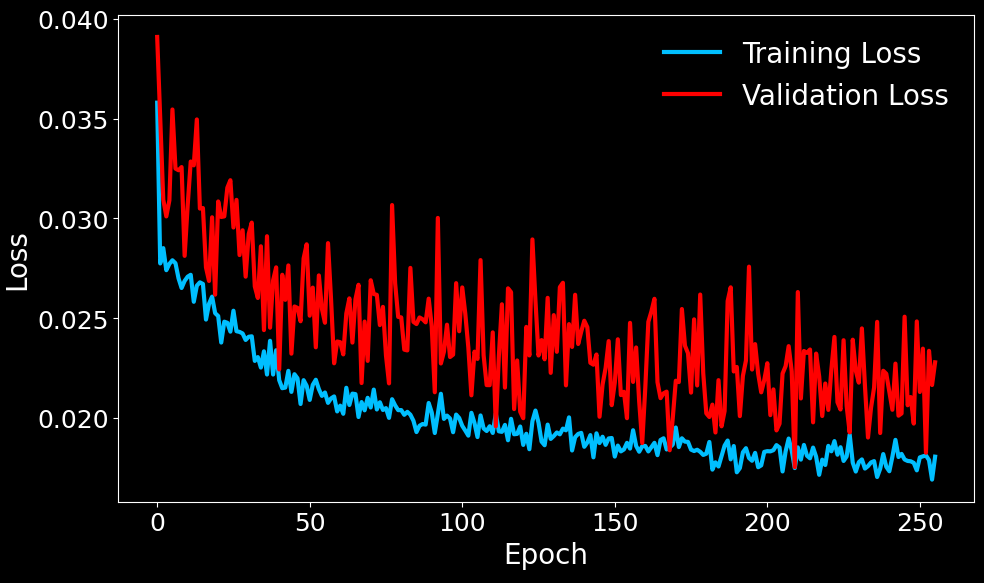

In [7]:
trainer.display_results()

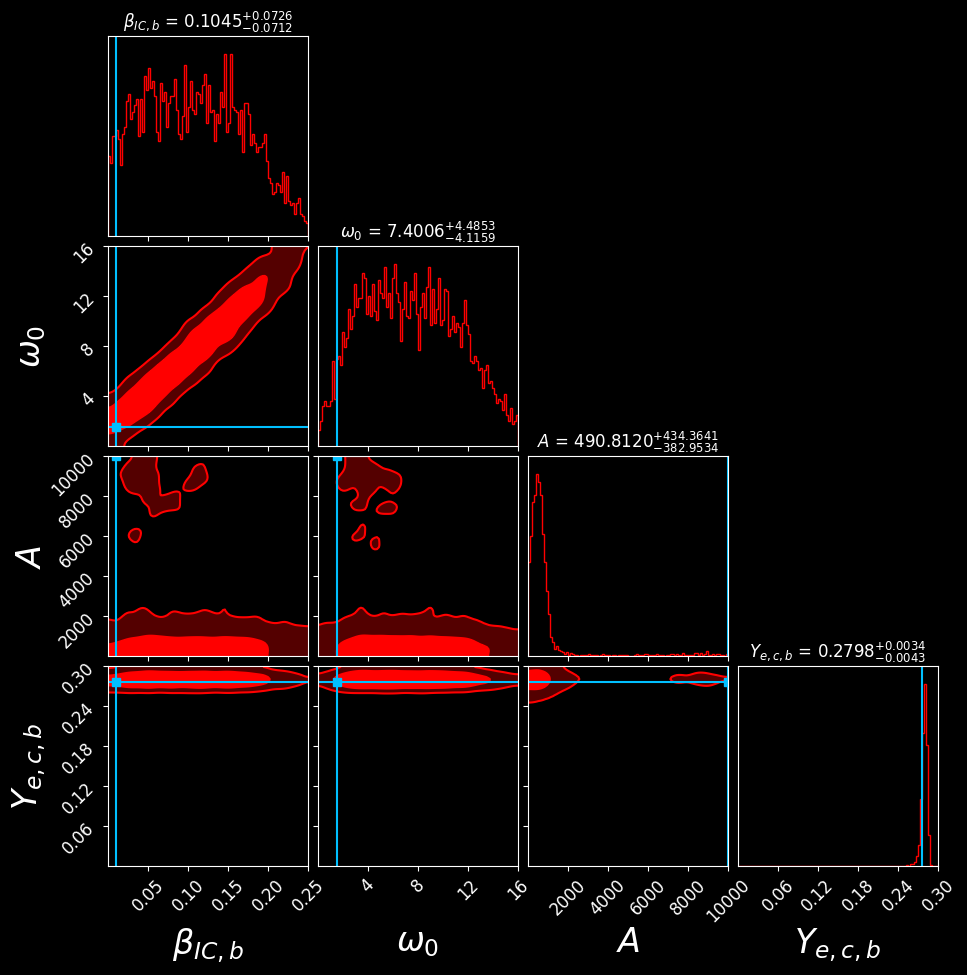

In [12]:
# trainer.val_loader.dataset.update_snr(20)
# signal, noisy_signal, params = trainer.val_loader.dataset.__getitem__(9)
# plot_candidate_signal(noisy_signal=noisy_signal/TEN_KPC, signal=signal/TEN_KPC, max_value=trainer.validation_dataset.max_strain, fname="plots/detected_signal.svg", background="black")
trainer.plot_corner(index=150, fname="plots/corner_plot.svg")

In [9]:
# get statistics for parameter values for test set in trainer.val_loader.dataset
params_list = []
params = trainer.validation_dataset.parameters
print(params.shape)
param_means = np.mean(params, axis=0)
param_stds = np.std(params, axis=0)
print("Parameter means:", param_means)  

(168, 4)
Parameter means: [7.872836e-02 5.735119e+00 1.536137e+03 2.760197e-01]


In [10]:
def plot_velocity_field_evolution(trainer, n_test_samples=300, n_steps=8, background="white", fname="plots/flow_evolution_1d_marginals.png"):
    """
    Visualize the evolution of parameter distributions through the velocity field.
    
    Args:
        trainer: FlowMatchingTrainer instance
        n_test_samples: Number of test samples to use
        n_steps: Number of flow steps to visualize
        background: "white" or "black" for plot styling
        fname: Filename to save the plot
    """
    from starccato_flow.plotting.plotting import set_plot_style
    
    # Set plot style based on background
    set_plot_style(background=background, font_family="sans-serif", font_name="Avenir")
    
    val_dataset = trainer.val_loader.dataset
    
    # Get true parameters and signals from validation set
    n_test_samples = min(n_test_samples, len(val_dataset))
    
    # Detect number of parameters dynamically
    sample_signal, sample_noisy, sample_params = val_dataset[0]
    num_params = sample_params.shape[-1]
    print(f"Number of parameters: {num_params}")
    
    true_params = torch.zeros(n_test_samples, num_params, device=DEVICE)
    test_signals = torch.zeros(n_test_samples, trainer.y_length, device=DEVICE)
    
    for i in range(n_test_samples):
        clean_signal, noisy_signal, params = val_dataset[i]
        true_params[i] = params.squeeze()
        test_signals[i] = noisy_signal.squeeze()
    
    # Start from noise in parameter space (independent 1D Gaussians)
    x = torch.randn(n_test_samples, num_params, device=DEVICE)
    time_steps = torch.linspace(0, 1.0, n_steps + 1)
    
    # Store snapshots for visualization
    snapshots = [x.detach().cpu().clone()]
    
    # Flow the samples
    for i in range(n_steps):
        x = trainer.flow.step(x, time_steps[i], time_steps[i + 1], test_signals)
        snapshots.append(x.detach().cpu().clone())
    
    # Visualize 1D marginal distributions evolving
    param_names = ['β', 'log(ω₀)', 'log(A)', 'Yₑ'] if num_params == 4 else ['Param 1', 'Param 2']
    
    # Color scheme based on background
    if background == "black":
        estimated_color = '#3498db'  # Blue
        true_color = '#e74c3c'  # Red
        text_color = 'white'
        grid_color = 'gray'
        grid_alpha = 0.3
    else:
        estimated_color = '#2980b9'  # Darker blue
        true_color = '#c0392b'  # Darker red
        text_color = 'black'
        grid_color = 'lightgray'
        grid_alpha = 0.5
    
    fig, axes = plt.subplots(num_params, n_steps + 1, figsize=(30, 4*num_params))
    if num_params == 1:
        axes = axes.reshape(1, -1)
    
    for param_idx in range(num_params):
        for step_idx, snapshot in enumerate(snapshots):
            ax = axes[param_idx, step_idx]
            
            # Plot histogram of this parameter dimension
            ax.hist(snapshot[:, param_idx].numpy(), bins=30, alpha=0.7, 
                    color=estimated_color, density=True, label='Estimated', edgecolor='none')
            ax.hist(true_params.cpu()[:, param_idx].numpy(), bins=30, alpha=0.5, 
                    color=true_color, density=True, label='True', edgecolor='none')
            
            if param_idx == 0:
                ax.set_title(f't = {time_steps[step_idx]:.2f}', fontsize=12, color=text_color)
            if step_idx == 0:
                ax.set_ylabel(f'{param_names[param_idx]}\nDensity', fontsize=10, color=text_color)
            if param_idx == num_params - 1:
                ax.set_xlabel('Value', fontsize=10, color=text_color)
            
            # Set x-limits based on parameter type
            if num_params == 4:
                ax.set_xlim(-1.5, 1.5)  # Normalized parameters
            else:
                ax.set_xlim(-1.5, 1.5)  # Normalized toy parameters
            
            if step_idx == 0:
                ax.legend(fontsize=8, framealpha=0.9)
            
            # Grid
            ax.grid(True, alpha=grid_alpha, color=grid_color, linestyle='--', linewidth=0.5)
            
            # Spine colors
            for spine in ax.spines.values():
                spine.set_edgecolor(text_color)
                spine.set_linewidth(0.5)
    
    title_text = '1D Marginal Distributions: Velocity Field Evolution from Gaussian to Target'
    plt.suptitle(title_text, fontsize=16, y=1.00, color=text_color)
    plt.tight_layout()
    plt.savefig(fname, dpi=150, bbox_inches='tight', facecolor=fig.get_facecolor())
    plt.show()

# Call the function
plot_velocity_field_evolution(trainer, n_test_samples=300, n_steps=8, background="white", 
                               fname="plots/flow_evolution_1d_marginals.png")

ModuleNotFoundError: No module named 'starccato_flow.plotting.plotting'